In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data = pd.read_csv("train.tsv",sep="\t")#encoding="latin"
data.head(5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
data.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

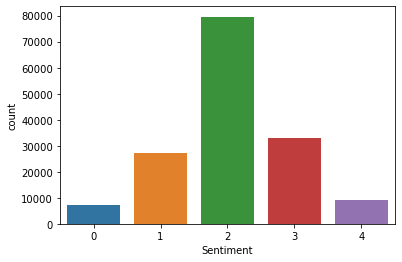

In [4]:
import seaborn as sns
data.groupby('Sentiment').describe
sns.countplot(data=data, x='Sentiment')

In [6]:
x_train,x_test,y_train,y_test = train_test_split(data.Phrase, data.Sentiment, test_size=0.5, random_state=37)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(78030,)
(78030,)
(78030,)
(78030,)


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorized_text = vectorizer.fit_transform(x_train)

# Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(vectorized_text,y_train)

MultinomialNB()

In [10]:
x_test_vector=vectorizer.transform(x_test)
final_prediction_NB=classifier.predict(x_test_vector)

In [11]:
count = 0
for i in range(len(y_test)):
    if y_test.iloc[i] != final_prediction_NB[i]:
        count += 1
print('Total number of test cases', ((len(y_test))))
print('Number of wrong of predictions', count)

Total number of test cases 78030
Number of wrong of predictions 31445


In [12]:
print(classification_report( y_test,final_prediction_NB))

              precision    recall  f1-score   support

           0       0.43      0.23      0.30      3590
           1       0.47      0.42      0.44     13586
           2       0.68      0.77      0.72     39896
           3       0.50      0.50      0.50     16427
           4       0.44      0.27      0.33      4531

    accuracy                           0.60     78030
   macro avg       0.50      0.44      0.46     78030
weighted avg       0.58      0.60      0.59     78030



AxesSubplot(0.125,0.125;0.62x0.755)


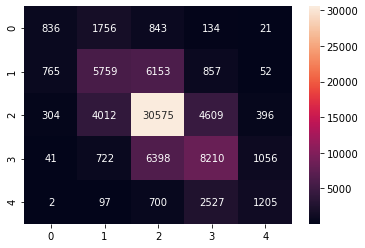

In [13]:
print(sns.heatmap(confusion_matrix(y_test,final_prediction_NB),annot=True,fmt=''))

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
classifier_logistic =  LogisticRegression(random_state=0)
classifier_logistic.fit(vectorized_text,y_train)

C:\Users\Dell\anaconda3\envs\venvt\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [15]:
final_prediction_LR=classifier_logistic.predict(x_test_vector)

In [16]:

print(classification_report( y_test,final_prediction_LR))

              precision    recall  f1-score   support

           0       0.51      0.28      0.36      3590
           1       0.52      0.37      0.43     13586
           2       0.69      0.86      0.76     39896
           3       0.57      0.47      0.51     16427
           4       0.54      0.32      0.40      4531

    accuracy                           0.64     78030
   macro avg       0.57      0.46      0.49     78030
weighted avg       0.62      0.64      0.61     78030



# ANN with embedding layers and precised mode

In [17]:
X=data.Phrase
Y=data.Sentiment
le=LabelEncoder()
Y=le.fit_transform(Y)

In [18]:
print(X.shape)
print(Y.shape)

(156060,)
(156060,)


In [19]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.5, random_state = 41)

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(78030,)
(78030,)
(78030,)
(78030,)


In [21]:
max_length = 120
vocab_size = 10000
embeding_dim = 16 
trunc_type = 'post'
oov_tok="<OOV>"

In [22]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing import sequence
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x_train)
padded_sequence=sequence.pad_sequences(sequences,padding='post',truncating=trunc_type,maxlen=max_length)

In [23]:
testing_sequence = tokenizer.texts_to_sequences(x_test)
padded_testing = sequence.pad_sequences(testing_sequence,padding='post',truncating=trunc_type,maxlen=max_length)

In [24]:
print(padded_sequence.shape)
print(y_train.shape)
print(padded_testing.shape)
print(y_test.shape)

(78030, 120)
(78030,)
(78030, 120)
(78030,)


In [25]:
import tensorflow

In [26]:
model=tensorflow.keras.Sequential([
    tensorflow.keras.layers.Embedding(vocab_size,embeding_dim,input_length=max_length),
    tensorflow.keras.layers.GRU(3),
    tensorflow.keras.layers.Dense(6,activation='relu'),
#     tf.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
gru (GRU)                    (None, 3)                 189       
_________________________________________________________________
dense (Dense)                (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 160,220
Trainable params: 160,220
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(padded_sequence,y_train,epochs=5,validation_data=(padded_testing,y_test),verbose=2)

Epoch 1/5
2439/2439 - 94s - loss: -1.0233e+02 - acc: 0.1740 - val_loss: -1.6940e+02 - val_acc: 0.1755
Epoch 2/5
2439/2439 - 93s - loss: -2.5825e+02 - acc: 0.1740 - val_loss: -3.5329e+02 - val_acc: 0.1755
Epoch 3/5
2439/2439 - 93s - loss: -4.7093e+02 - acc: 0.1740 - val_loss: -5.9175e+02 - val_acc: 0.1755
Epoch 4/5
2439/2439 - 94s - loss: -7.3795e+02 - acc: 0.1740 - val_loss: -8.8385e+02 - val_acc: 0.1755
Epoch 5/5
2439/2439 - 93s - loss: -1.0583e+03 - acc: 0.1740 - val_loss: -1.2285e+03 - val_acc: 0.1755


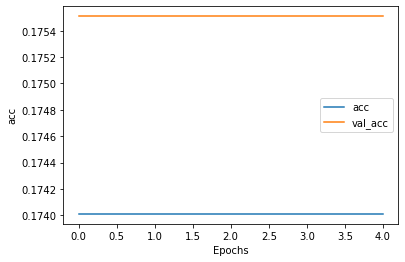

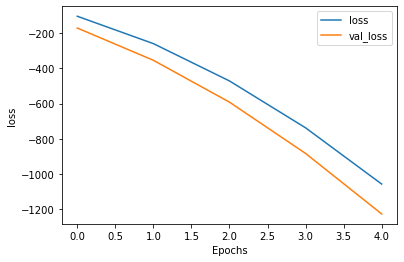

In [29]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "acc")
plot_graphs(history, "loss")

# Bidirectional convolutional layer

In [30]:
from tensorflow.keras import regularizers
model1 = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Embedding(vocab_size,embeding_dim,input_length = max_length),
    tensorflow.keras.layers.Bidirectional(tensorflow.keras.layers.LSTM(64)),
    tensorflow.keras.layers.Dense(64,activation='relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(1,activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),metrics=['acc'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_________________________________________________________________


In [32]:
earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
history1 = model1.fit(padded_sequence,y_train,epochs=5,validation_data=(padded_testing,y_test),verbose=2,callbacks=[earlystop])

Epoch 1/5
2439/2439 - 179s - loss: -3.2458e+04 - acc: 0.1740 - val_loss: -7.1296e+04 - val_acc: 0.1755
Epoch 2/5
2439/2439 - 181s - loss: -1.2956e+05 - acc: 0.1740 - val_loss: -1.9417e+05 - val_acc: 0.1755
Epoch 3/5
2439/2439 - 175s - loss: -2.7683e+05 - acc: 0.1740 - val_loss: -3.6395e+05 - val_acc: 0.1755
Epoch 4/5
2439/2439 - 174s - loss: -4.7063e+05 - acc: 0.1740 - val_loss: -5.7726e+05 - val_acc: 0.1755
Epoch 5/5
2439/2439 - 174s - loss: -7.0926e+05 - acc: 0.1740 - val_loss: -8.3595e+05 - val_acc: 0.1755


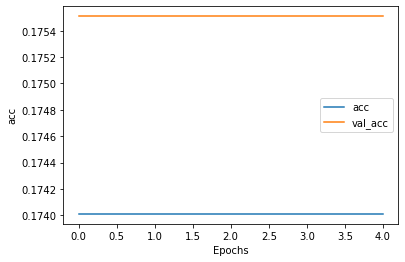

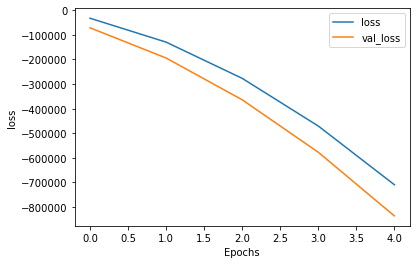

In [33]:
plot_graphs(history1, "acc")
plot_graphs(history1, "loss")


In [1]:
#!pip install prettytable
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.field_names=["Model Name","Test Accuracy"]
ptable.add_row(["Naive Bayes","61%"])
ptable.add_row(["Logistic Regression","64%"])
ptable.add_row(["ANN with 1 hidden layer and RNN","17.55%"])
ptable.add_row(["ANN with 1 hidden layer and LSTM","17.55%"])

print(ptable)
print()

+----------------------------------+---------------+
|            Model Name            | Test Accuracy |
+----------------------------------+---------------+
|           Naive Bayes            |      61%      |
|       Logistic Regression        |      64%      |
| ANN with 1 hidden layer and RNN  |     17.55%    |
| ANN with 1 hidden layer and LSTM |     17.55%    |
+----------------------------------+---------------+



In [1]:
!pip install anvil-uplink

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=813ed2b8abc4f46bc311fa00c72333f83b066c5e674c17c1b813ecb17be2fc17
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\8e\70\28\3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45215 sha256=85b81e99382887b04a18b6eab1639a2ba8a265c7fd69a2d58a203c8fef187f8e
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\ea\f9\a1\34e2943cce3cf7daca304bfc35e91280694ced9194a487ce2f
Successfully built future ws4py
